In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

from alexnet import AlexNet
from image_loader import load_images
from util import shuffle, get_batch

### Set hyperparameters

In [2]:
np.random.seed(9002)

global_step = tf.Variable(0, trainable=False)
boundaries = [160, 320]
values = [0.0003, 0.0001, 0.00001]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

num_epochs = 3
batch_size = 128

dropout_rate = 0.5
num_classes = 1

# how often to write tf.summary to disk
display_step = 20

### Build computation graph

Building the CNN is in the `./alexnet.py` file. This is also used in `./eval.py` which just makes predictions, so it makes sense to put it in a separate file in order to reuse.

In [3]:
X = tf.placeholder(tf.float32, shape=(batch_size, 150, 150, 1), name="X")
Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes), name="Y")
dropout = tf.placeholder(tf.float32, name="dropout_rate")

model = AlexNet(X, dropout, num_classes)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model.logits, labels=Y))

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimization_op = optimizer.minimize(loss)

tf.summary.scalar('loss', loss)

with tf.name_scope("accuracy"):
    predictions = model.logits > 0
    correct_predictions = tf.equal(predictions, Y > 0)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

tf.summary.scalar('training_accuracy', accuracy)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./tensorboard")
saver = tf.train.Saver()

### Load image data into memory

Only takes about 1-2GB of memory, so we can load it all into memory at once.

In [4]:
molecule_images = load_images(["./positives/images/*.png", "./positives/manually-collected/*.png"])
non_molecule_images = load_images(["./negatives/tiles/*.png", "./negatives/manually-collected/*.png"])

### Munge data

Generate the right labels, shuffle randomly, and partition training and test sets.

In [5]:
n_pos = molecule_images.shape[0]
n_neg = non_molecule_images.shape[0]

print("positives", n_pos)
print("negatives", n_neg)

positive_labels = np.ones(n_pos)
negative_labels = np.zeros(n_neg)

x = np.vstack((molecule_images, non_molecule_images))
y = np.concatenate((positive_labels, negative_labels)).reshape((-1, 1))

m = x.shape[0]

x, y = shuffle(x, y)

train_x = x[:-2000]
train_y = y[:-2000]

test_x = x[-2000:]
test_y = y[-2000:]

positives 12094
negatives 10398


### Preview
Display some labels and images.

[ 1.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]


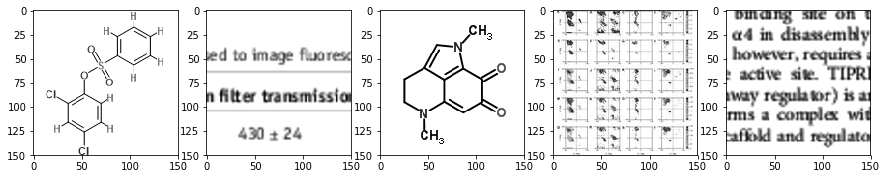

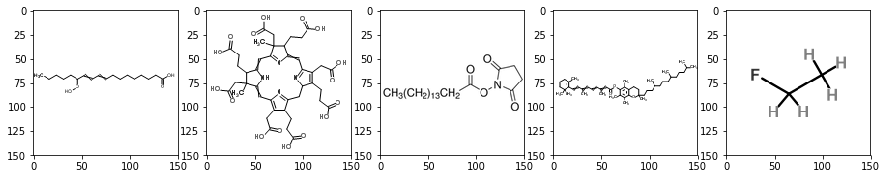

In [6]:
for i in range(2):
    fig = plt.figure(figsize=(15, 15))
    for j in range(5):
        print(y[i * 5 + j])
        sub = fig.add_subplot(1, 5, j + 1)
        sub.imshow(np.squeeze(x[i * 5 + j]), cmap="gray")

plt.show()        

### Training

In [7]:
training_batches_per_epoch = int(np.floor(train_x.shape[0] / batch_size))
test_batches_per_epoch = int(np.floor(test_x.shape[0] / batch_size))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x, train_y = shuffle(train_x, train_y)
        
        for step in tqdm(range(training_batches_per_epoch)):
            x_batch, y_batch = get_batch(train_x, train_y, step, batch_size)
            sess.run(optimization_op, feed_dict={X: x_batch, Y: y_batch, dropout: dropout_rate })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(merged_summary, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                writer.add_summary(summ, epoch * training_batches_per_epoch + step)
                writer.flush()

        test_acc = 0
        test_count = 0
        for step in range(test_batches_per_epoch):
            x_batch, y_batch = get_batch(test_x, test_y, step, batch_size)
            acc = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
            test_acc += acc
            test_count += 1

        print("test accuracy = {:.4f}".format(test_acc / test_count))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./tensorflow-ckpt/model.ckpt")

2018-01-04 15:03:13.197519 epoch number: 1


100%|██████████| 160/160 [07:11<00:00,  2.70s/it]


test accuracy = 0.9854
2018-01-04 15:10:35.641495 epoch number: 2


100%|██████████| 160/160 [07:18<00:00,  2.74s/it]


test accuracy = 0.9865
2018-01-04 15:18:04.770562 epoch number: 3


100%|██████████| 160/160 [07:11<00:00,  2.70s/it]


test accuracy = 0.9911
